# Импорт модулей

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Инициализация Spark

In [2]:
spark = SparkSession.builder\
                    .master('local[*]')\
                    .appName('Logs analisys')\
                    .config("spark.driver.bindAddress", "127.0.0.1")\
                    .getOrCreate()

# Загрузка данных

In [3]:
log_data = spark.read.option('header', True)\
                .csv('/Users/alenakapustan/Git/log_analysis/data/weblog.csv')

## Исслудуем загруженные данные

In [4]:
log_data.printSchema()

root
 |-- IP: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- Staus: string (nullable = true)



In [5]:
log_data.show()

+----------+--------------------+--------------------+-----+
|        IP|                Time|                 URL|Staus|
+----------+--------------------+--------------------+-----+
|10.128.2.1|[29/Nov/2017:06:5...|GET /login.php HT...|  200|
|10.128.2.1|[29/Nov/2017:06:5...|POST /process.php...|  302|
|10.128.2.1|[29/Nov/2017:06:5...|GET /home.php HTT...|  200|
|10.131.2.1|[29/Nov/2017:06:5...|GET /js/vendor/mo...|  200|
|10.130.2.1|[29/Nov/2017:06:5...|GET /bootstrap-3....|  200|
|10.130.2.1|[29/Nov/2017:06:5...|GET /profile.php?...|  200|
|10.128.2.1|[29/Nov/2017:06:5...|GET /js/jquery.mi...|  200|
|10.131.2.1|[29/Nov/2017:06:5...|GET /js/chart.min...|  200|
|10.131.2.1|[29/Nov/2017:06:5...|GET /edit.php?nam...|  200|
|10.131.2.1|[29/Nov/2017:06:5...|GET /logout.php H...|  302|
|10.131.2.1|[29/Nov/2017:06:5...|GET /login.php HT...|  200|
|10.130.2.1|[29/Nov/2017:07:0...|GET /login.php HT...|  200|
|10.130.2.1|[29/Nov/2017:07:0...|GET /login.php HT...|  200|
|10.130.2.1|[29/Nov/2017

In [6]:
log_data.select([f.count(f.when(f.isnan(col) | f.col(col).isNull(), col))
                 .alias('{}_isNull'.format(col)) for col in log_data.columns])\
        .show()

+---------+-----------+----------+------------+
|IP_isNull|Time_isNull|URL_isNull|Staus_isNull|
+---------+-----------+----------+------------+
|        0|          0|         0|           0|
+---------+-----------+----------+------------+



In [7]:
log_data.count()

16007

# Обработка данных

## Формируем паттерны для извлечения данных с помощью регулярных выражений

In [8]:
date_pattern = r'\d{2}/\w{3}/\d{4}'
time_pattern = r'\d{2}:\d{2}:\d{2}'
status_code_pattern = r'[GETPOSUDL]{3,6}'
protocol_pattern = r'HTTPS?/\d+\.\d+'
endpoint_pattern = r'/\b\D+[./]+[^\s][\w\d]+'
domain_pattern = r'\w+'
status_pattern = r'\d{3}'

## Трансформируем первоначальный датафрейм

In [9]:
log_data_new = log_data.select('IP'
                           , f.when((f.regexp_extract('Time', date_pattern, 0)) != ""
                                     , f.regexp_extract('Time', date_pattern, 0))
                               .otherwise(None)
                               .alias('Date')
                           , f.when((f.regexp_extract('Time', time_pattern, 0)) != ""
                                    , f.regexp_extract('Time', time_pattern, 0))
                               .otherwise(None)
                               .alias('Time')
                           , f.when((f.regexp_extract('URL', status_code_pattern, 0)) != ""
                                    , f.regexp_extract('URL', status_code_pattern, 0))
                               .otherwise(None)
                               .alias('Method')
                           , f.when((f.regexp_extract('URL', endpoint_pattern, 0)) != ""
                                    , f.regexp_extract('URL', endpoint_pattern, 0))
                               .otherwise(None)
                               .alias('Endpoint')
                           , f.when((f.regexp_extract('URL', protocol_pattern, 0)) != ""
                                    , f.regexp_extract('URL', protocol_pattern, 0))
                               .otherwise(None)
                               .alias('Protocol')
                           , f.when((f.regexp_extract('Staus', status_pattern, 0)) != ""
                                    , f.regexp_extract('Staus', status_pattern, 0))
                               .otherwise(None)
                               .alias('Status')
                          )\
                        .withColumn('Date', f.from_unixtime(f.unix_timestamp('Date', 'dd/MMM/yyyy'), 'yyyy-MM-dd')).alias('date')

Смотрим что получилось

In [10]:
log_data_new.show(5)

+----------+----------+--------+------+--------------------+--------+------+
|        IP|      Date|    Time|Method|            Endpoint|Protocol|Status|
+----------+----------+--------+------+--------------------+--------+------+
|10.128.2.1|2017-11-29|17:06:58|   GET|          /login.php|HTTP/1.1|   200|
|10.128.2.1|2017-11-29|17:06:59|  POST|        /process.php|HTTP/1.1|   302|
|10.128.2.1|2017-11-29|17:06:59|   GET|           /home.php|HTTP/1.1|   200|
|10.131.2.1|2017-11-29|17:06:59|   GET|/js/vendor/moment...|HTTP/1.1|   200|
|10.130.2.1|2017-11-29|17:06:59|   GET|    /js/bootstrap.js|HTTP/1.1|   200|
+----------+----------+--------+------+--------------------+--------+------+
only showing top 5 rows



In [11]:
log_data_new.count()

16007

In [12]:
log_data_new.groupBy('Method').count().show()

+------+-----+
|Method|count|
+------+-----+
|  POST|  682|
|  null|  218|
|   TTP|    9|
|   GET|15098|
+------+-----+



In [13]:
log_data_new.select([f.count(f.when(f.isnan(col) | f.col(col).isNull(), col))
                     .alias('{}_isNull'.format(col)) for col in log_data_new.columns])\
            .show()

+---------+-----------+-----------+-------------+---------------+---------------+-------------+
|IP_isNull|Date_isNull|Time_isNull|Method_isNull|Endpoint_isNull|Protocol_isNull|Status_isNull|
+---------+-----------+-----------+-------------+---------------+---------------+-------------+
|        0|        218|        218|          218|           1080|            218|          183|
+---------+-----------+-----------+-------------+---------------+---------------+-------------+



### Анализирум данные, которые не соответствуют шаблонам (т.е те, которые были заполнены Null)

Колонка Time - видим, что отсеились данные, которые были заполнены не корректно

In [14]:
log_data.filter(~log_data['Time'].rlike(date_pattern))\
        .groupBy('Time')\
        .count().alias('count')\
        .orderBy(f.col('count').desc())\
        .show()

+--------------------+-----+
|                Time|count|
+--------------------+-----+
|              cannot|  167|
|                 Jan|   16|
|                 Feb|   12|
|                 Dec|    7|
|                 the|    5|
|                line|    5|
|        main.cpp:51:|    3|
|C:WINDOWSSystem32...|    2|
|        main.cpp:64:|    1|
+--------------------+-----+



Колонка Staus - видим, что отсеились данные, которые были заполнены не корректно

In [15]:
log_data.filter(~log_data['Staus'].rlike(status_pattern))\
        .groupBy('Staus')\
        .count().alias('count')\
        .orderBy(f.col('count').desc())\
        .show()

+------------+-----+
|       Staus|count|
+------------+-----+
|          No|  167|
|      dumped|    5|
|   Assertion|    4|
|     Aborted|    4|
|       found|    2|
|Segmentation|    1|
+------------+-----+



Колонка URL, новая колонка - Method

In [16]:
method = log_data.filter(~log_data['URL'].rlike(status_code_pattern))\
                            .groupBy('URL')\
                            .count().alias('count')\
                            .orderBy(f.col('count').desc())

In [17]:
method.count()

22

In [18]:
method.show(22)

+------------+-----+
|         URL|count|
+------------+-----+
|'error.txt':|   64|
|      '*.o':|   62|
|    'a.out':|   41|
|     48:37.1|    5|
|     52:06.9|    5|
|     command|    5|
|     02:49.8|    5|
|     24:12.8|    5|
|     12:58.7|    5|
|     29:09.2|    5|
|     main():|    4|
|         not|    2|
|        1192|    1|
|         451|    1|
|     40:28.7|    1|
|     51:47.0|    1|
|     00:53.4|    1|
|     44:47.7|    1|
|        1243|    1|
|         848|    1|
|     20:28.3|    1|
|        1226|    1|
+------------+-----+



Колонка URL, новая колонка - Endpoint

In [19]:
end_point = log_data.filter(~log_data['URL'].rlike(endpoint_pattern))\
                    .groupBy('URL')\
                    .count().alias('count')\
                    .orderBy(f.col('count').desc())

In [20]:
end_point.count()

24

Колонка URL, новая колонка - Protocol

In [21]:
protocol = log_data.filter(~log_data['URL'].rlike(protocol_pattern))\
                            .groupBy('URL')\
                            .count().alias('count')\
                            .orderBy(f.col('count').desc())

In [22]:
protocol.count()

22

In [23]:
# проверяем какие из значений колонки Method отсутствуют в колонке Protocol
protocol.exceptAll(method).show()

+---+-----+
|URL|count|
+---+-----+
+---+-----+



In [24]:
# проверяем какие из значений колонки Method отсутствуют в колонке Endpoint
end_point.exceptAll(method).show()

+--------------+-----+
|           URL|count|
+--------------+-----+
|GET / HTTP/1.0|    1|
|GET / HTTP/1.1|  861|
+--------------+-----+



Исключаем записи с нулевыми значениями из колонок Date, Time, Method, Protocol, Status, Endpoint

In [25]:
log_data_filt = log_data_new.filter(f.col('Date').isNotNull()
                                    | f.col('Time').isNotNull()
                                    | f.col('Method').isNotNull()
                                    | f.col('Protocol').isNotNull())\
                            .filter(f.col('Status').isNotNull())\
                            .filter(f.col('Endpoint').isNotNull())\
                            .filter(f.col('Method') != 'TTP')

Считаем колонки с нулевыми значениями после удаления

In [26]:
log_data_filt.select([f.count(f.when(f.isnan(col) | f.col(col).isNull(), col)).alias('{}_isNull'.format(col)) for col in log_data_filt.columns]).show()

+---------+-----------+-----------+-------------+---------------+---------------+-------------+
|IP_isNull|Date_isNull|Time_isNull|Method_isNull|Endpoint_isNull|Protocol_isNull|Status_isNull|
+---------+-----------+-----------+-------------+---------------+---------------+-------------+
|        0|          0|          0|            0|              0|              0|            0|
+---------+-----------+-----------+-------------+---------------+---------------+-------------+



In [27]:
log_data_filt.count()

14918

# Анализ данных

## Общий анализ статусов запросов

In [28]:
status_df = (log_data_filt
                     .groupBy('Status')
                     .count()
                     .sort('Status')
                     .cache())
print('Общее количество уникальных статусов HTTP:', status_df.count())  

Общее количество уникальных статусов HTTP: 5


In [29]:
status_pd_df = (status_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_pd_df

,Status,count
0,200,11205
2,302,2752
3,304,658
4,404,251
1,206,52


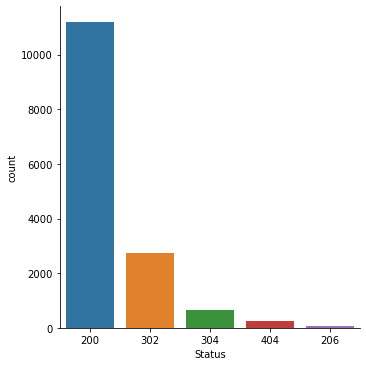

In [30]:
sns.catplot(x='Status', y='count', data=status_pd_df,
            kind='bar', order=status_pd_df['Status'])

## Анализ наиболее часто встречающихся запросов

In [31]:
endpoint_sum_df =(log_data_filt
               .groupBy('Endpoint')
               .count()
               .sort('count', ascending=False).limit(10))

endpoint_sum_df.show()

+--------------------+-----+
|            Endpoint|count|
+--------------------+-----+
|          /login.php| 3422|
|           /home.php| 2650|
|/js/vendor/modernizr| 1417|
| /contestproblem.php|  556|
|  /css/normalize.css|  408|
|/css/bootstrap.mi...|  404|
|/css/font-awesome...|  399|
|      /css/style.css|  395|
|       /css/main.css|  394|
|   /js/vendor/jquery|  387|
+--------------------+-----+



In [32]:
endpoint_sum_pd_df = endpoint_sum_df.toPandas()

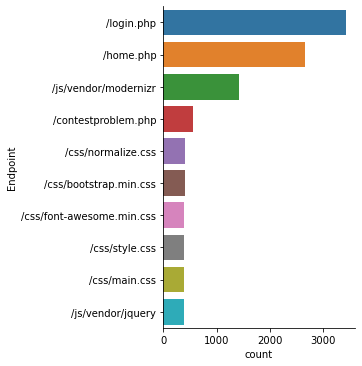

In [33]:
sns.catplot(x='count', y='Endpoint', data=endpoint_sum_pd_df,
            kind='bar', order=endpoint_sum_pd_df['Endpoint'])

## Наиболее активные пользоатели

In [34]:
users_df = log_data_filt.groupBy('IP')\
                .count()\
                .orderBy(f.col('count').desc())\
                .sort('count', ascending=False).limit(10)
users_df.show()

+----------+-----+
|        IP|count|
+----------+-----+
|10.128.2.1| 4050|
|10.131.0.1| 3977|
|10.130.2.1| 3885|
|10.129.2.1| 1518|
|10.131.2.1| 1488|
+----------+-----+



In [35]:
users_pd_df = users_df.toPandas()

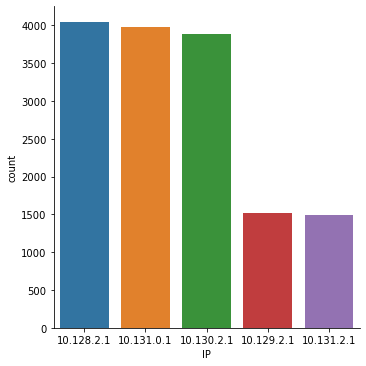

In [36]:
sns.catplot(x='IP', y='count', data=users_pd_df,
            kind='bar', order=users_pd_df['IP'])

## Нагрузка (по количеству запросов)

In [37]:
log_data_filt.withColumn('Year', f.year('Date'))\
                .groupBy('Year')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+----+-----+
|Year|count|
+----+-----+
|2017| 8399|
|2018| 6519|
+----+-----+



### Отбираем для анализа 2017 год

In [38]:
log_data_filt_2017 = log_data_filt.filter(f.year('Date') == 2017)

In [39]:
queries_by_dates_df = log_data_filt_2017.groupBy('Date')\
                .count()\
                .orderBy(f.col('count').desc())
queries_by_dates_df.show(5)

+----------+-----+
|      Date|count|
+----------+-----+
|2017-11-30| 2836|
|2017-11-29|  550|
|2017-11-17|  444|
|2017-12-01|  434|
|2017-11-23|  356|
+----------+-----+
only showing top 5 rows



In [40]:
queries_by_dates_pd_df = queries_by_dates_df.toPandas()

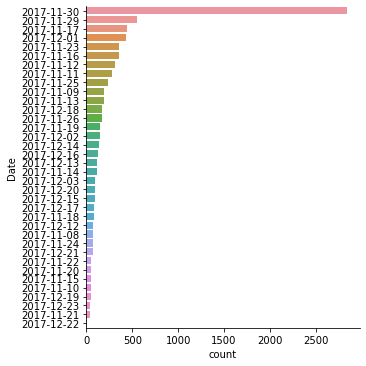

In [41]:
sns.catplot(x='count', y='Date', data=queries_by_dates_pd_df,
            kind='bar', order=queries_by_dates_pd_df['Date'])

#### Нагрузка по месяцам в 2017 году

In [42]:
log_data_filt_2017.withColumn('Month', f.month('Date'))\
                .groupBy('Month')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+-----+-----+
|Month|count|
+-----+-----+
|   11| 6646|
|   12| 1753|
+-----+-----+



#### Нагрузка по дням в ноябре 2017 года

In [43]:
log_data_filt_2017.filter(f.month('Date') == 11)\
                    .withColumn('Day', f.dayofmonth('Date'))\
                    .groupBy('Day')\
                    .count()\
                    .orderBy(f.col('count').desc())\
                    .show()

+---+-----+
|Day|count|
+---+-----+
| 30| 2836|
| 29|  550|
| 17|  444|
| 23|  356|
| 16|  352|
| 12|  308|
| 11|  278|
| 25|  239|
|  9|  190|
| 13|  188|
| 26|  169|
| 19|  149|
| 14|  114|
| 18|   79|
|  8|   74|
| 24|   74|
| 20|   53|
| 22|   53|
| 15|   52|
| 10|   50|
+---+-----+
only showing top 20 rows



#### Нагрузка по дням в декабре 2017 года

In [44]:
log_data_filt_2017.filter(f.month('Date') == 12)\
                .withColumn('Day', f.dayofmonth('Date'))\
                .groupBy('Day')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+---+-----+
|Day|count|
+---+-----+
|  1|  434|
| 18|  174|
|  2|  148|
| 14|  139|
| 16|  131|
| 13|  118|
|  3|   98|
| 20|   94|
| 15|   93|
| 17|   81|
| 12|   76|
| 21|   71|
| 19|   45|
| 23|   41|
| 22|   10|
+---+-----+



#### Нагрузка по временным интервалам

In [45]:
morning = log_data_filt_2017.filter((f.col('Time') >= '06:00:00') & (f.col('Time') < '12:00:00')).count()
morning

0

In [46]:
day = log_data_filt_2017.filter((f.col('Time') >= '12:00:00') & (f.col('Time') < '18:00:00'))
day.count()

8399

Смотрим в разбивке по часам

In [47]:
day.withColumn('Hour', f.hour('Time'))\
    .groupBy('Hour')\
    .count()\
    .orderBy(f.col('count').desc())\
    .show()

+----+-----+
|Hour|count|
+----+-----+
|  17| 8399|
+----+-----+



In [48]:
evening = log_data_filt_2017.filter((f.col('Time') >= '18:00:00') & (f.col('Time') < '24:00:00'))
evening.count()

0

In [49]:
night = log_data_filt_2017.filter((f.col('Time') >= '24:00:00') & (f.col('Time') < '06:00:00')).count()
night

0

#### Статусы ответов на запросы в 2017 году

In [50]:
req_status_df_2017 = log_data_filt_2017.groupBy('Status').count().sort('count', ascending=False)
req_status_df_2017.show()

+------+-----+
|Status|count|
+------+-----+
|   200| 6928|
|   304|  619|
|   302|  600|
|   404|  206|
|   206|   46|
+------+-----+



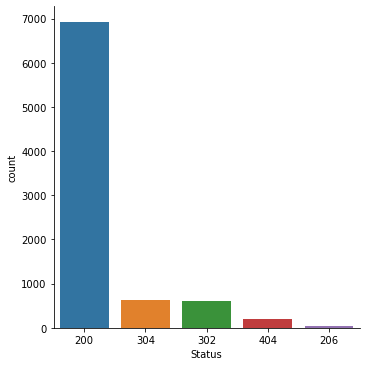

In [51]:
req_status_pd_df_2017 = req_status_df_2017.toPandas()
sns.catplot(x='Status', y='count', data=req_status_pd_df_2017,
            kind='bar', order=req_status_pd_df_2017['Status'])

#### Методы запросов в 2017 году

In [52]:
log_data_filt_2017.groupBy('Method').count().sort('count', ascending=False).show()

+------+-----+
|Method|count|
+------+-----+
|   GET| 7809|
|  POST|  590|
+------+-----+



### Отбираем для анализа 2018 год

In [53]:
log_data_filt_2018 = log_data_filt.filter(f.year('Date') == 2018)

In [54]:
queries_by_dates_df = log_data_filt_2018.groupBy('Date')\
                .count()\
                .orderBy(f.col('count').desc())
queries_by_dates_df.show(5)

+----------+-----+
|      Date|count|
+----------+-----+
|2018-01-29| 5076|
|2018-02-22|  224|
|2018-02-25|  136|
|2018-03-02|  135|
|2018-02-23|  127|
+----------+-----+
only showing top 5 rows



In [55]:
queries_by_dates_pd_df = queries_by_dates_df.toPandas()

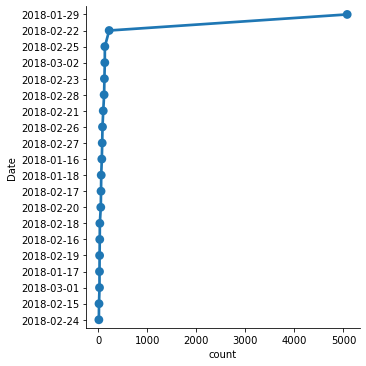

In [56]:
sns.catplot(x='count', y='Date', data=queries_by_dates_pd_df,
            kind='point', order=queries_by_dates_pd_df['Date'])

#### Нагрузка по месяцам в 2018 году

In [57]:
log_data_filt_2018.withColumn('Month', f.month('Date'))\
                .groupBy('Month')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+-----+-----+
|Month|count|
+-----+-----+
|    1| 5239|
|    2| 1118|
|    3|  162|
+-----+-----+



#### Нагрузка по дням в январе 2018 года

In [58]:
log_data_filt_2018.filter(f.month('Date') == 1)\
                .withColumn('Day', f.dayofmonth('Date'))\
                .groupBy('Day')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+---+-----+
|Day|count|
+---+-----+
| 29| 5076|
| 16|   74|
| 18|   62|
| 17|   27|
+---+-----+



#### Нагрузка по дням в феврале 2018 года

In [59]:
log_data_filt_2018.filter(f.month('Date') == 2)\
                .withColumn('Day', f.dayofmonth('Date'))\
                .groupBy('Day')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+---+-----+
|Day|count|
+---+-----+
| 22|  224|
| 25|  136|
| 23|  127|
| 28|  121|
| 21|  103|
| 26|   88|
| 27|   82|
| 17|   58|
| 20|   53|
| 18|   34|
| 16|   32|
| 19|   29|
| 15|   17|
| 24|   14|
+---+-----+



#### Нагрузка по дням в марте 2018 года

In [60]:
log_data_filt_2018.filter(f.month('Date') == 3)\
                .withColumn('Day', f.dayofmonth('Date'))\
                .groupBy('Day')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+---+-----+
|Day|count|
+---+-----+
|  2|  135|
|  1|   27|
+---+-----+



#### Нагрузка по временным интервалам

In [61]:
morning = log_data_filt_2018.filter((f.col('Time') >= '06:00:00') & (f.col('Time') < '12:00:00')).count()
morning

0

In [62]:
day = log_data_filt_2018.filter((f.col('Time') >= '12:00:00') & (f.col('Time') < '18:00:00'))
day.count()

0

In [63]:
evening = log_data_filt_2018.filter((f.col('Time') >= '18:00:00') & (f.col('Time') < '24:00:00'))
evening.count()

6519

Смотрим в разбивке по часам

In [64]:
evening.withColumn('Hour', f.hour('Time'))\
    .groupBy('Hour')\
    .count().alias('count')\
    .orderBy(f.col('count').desc())\
    .show()

+----+-----+
|Hour|count|
+----+-----+
|  18| 6519|
+----+-----+



In [65]:
night = log_data_filt.filter((f.col('Time') >= '24:00:00') & (f.col('Time') < '06:00:00')).count()
night

0

#### Статусы ответов на запросы в 2018 году

In [66]:
req_status_df_2018 = log_data_filt_2018.groupBy('Status')\
                                            .count()\
                                            .sort('count', ascending=False)
req_status_df_2018.show()

+------+-----+
|Status|count|
+------+-----+
|   200| 4277|
|   302| 2152|
|   404|   45|
|   304|   39|
|   206|    6|
+------+-----+



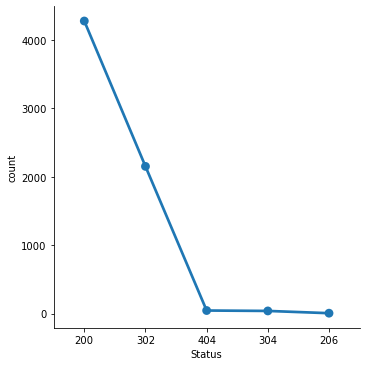

In [67]:
req_status_pd_df_2018 = req_status_df_2018.toPandas()
sns.catplot(x='Status', y='count', data=req_status_pd_df_2018,
            kind='point', order=req_status_pd_df_2018['Status'])

In [68]:
log_data_filt_2018_st = log_data_filt_2018.filter(f.col('Status') != '200')

In [69]:
log_data_filt_2018_st_df = log_data_filt_2018_st.groupBy('Date')\
                                                .count()\
                                                .orderBy(f.col('count').desc())
log_data_filt_2018_st_pd_df = log_data_filt_2018_st_df.toPandas()

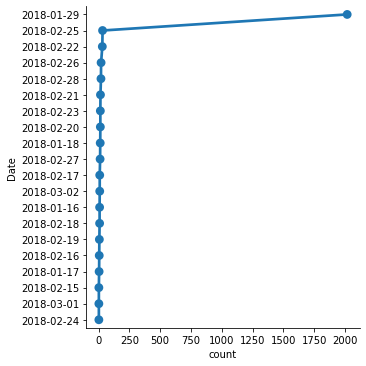

In [70]:
sns.catplot(x='count', y='Date', data=log_data_filt_2018_st_pd_df,
            kind='point', order=log_data_filt_2018_st_pd_df['Date'])

In [71]:
log_data_filt_2018_st.withColumn('Month', f.month('Date'))\
                .groupBy('Month')\
                .count()\
                .orderBy(f.col('count').desc())\
                .show()

+-----+-----+
|Month|count|
+-----+-----+
|    1| 2043|
|    2|  188|
|    3|   11|
+-----+-----+



In [72]:
#### Методы запросов в 2018 году

In [73]:
log_data_filt_2018.groupBy('Method').count().show()

+------+-----+
|Method|count|
+------+-----+
|  POST|   92|
|   GET| 6427|
+------+-----+



In [74]:
spark.stop()

# Выводы

In [ ]:
Есть падение пользовательской активности на 12,6% в 2018 году (6519 запросов) по сравнению с 2017 годом (8399 запросов).
В 2017 году пик активности 79,13% пришелся на ноябрь (6646), половина запросов сделана 29 (550) и 30 (2836) ноября.
В 2018 году пик активности 80,37% пришелся на январь (5239), большая часть запросов сделана 29 января (5076), в феврале наблюдается значительное падение
пользовательской активности на 77,97% (1118), в марте совершено всего 162 запроса.
Все запросы в 2017 году были совершены во временной интервал с 17.00 до 18.00, в 2018 году с 18.00 до 19.00.
Большая часть запросов, а именно 82,47%, в 2017 году отработаны со статусом 200 - Успешный запрос (6928), в 2018 году 4277 запросов обработаны со статусом
200, что составляет 65,61%. При этом наблюдается снижение успешной обработки запросов, что могло повлиять снижение пользовательской активности.
В основном в 2017 году ползователи направляли GET запросы (7809) - 92,98%, POST (590) - 7,02%, аналогично в 2018 году GET запросы (6427) - 98,49%, POST (92)
- 1,41%
Больше всего запросов 27,15% было отправлено с IP-адреса 10.128.2.1, на втором месте 10.131.0.1 - 26,7%, на третьем 10.130.2.1 - 26,04%
Наиболее популярные ресурсы login.php - 22,94%, home.php - 17,77%